# Histopathologic Cancer Detection Resnet 50 Model

The goal of this project is to train a Convolutional Neural Network, specifically Resnet with 50 layers, in order to identify if the center of the image of a body tissue collected from a pathology scan contains cancerous tissues or not. This is a binary classification problem, meaning that each training example is labeled as either being cancerous(1) or not cancerous(0). 

Cancerous in this case means that at least one pixel of the image contains tumorous tissue.


The dataset is based on PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates). The source of this data is this Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection

The dataset consists of 220025 training images that are all labeled with if they are cancerous or not. Additionally, there are 57458 unlabeled test images. The goal of this project for the built neural network to predict reasonably well the labels on this test set. The test data set does not come with test labels, so the test performance will be gotten by making submissions to the kaggle competition.

It is to be noted that while we can make submissions the public leaderboard for this competition has been freezed. We can still submit to get the AUC which is the performance metric for this project but we will not get into public leaderboard.

## 1. Packages

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform

import os
import shutil
import json

from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [6]:
# Creating a function to streamline the Train data set   
def train_img_path(id_str):
    return os.path.join(r"/kaggle/input/histopathologic-cancer-detection/train", f"{id_str}.tif")

## 2. Exploratory Data Analysis

In this section we will load the data and do cleaning if needed and then perform basic EDA.

However it is to be noted that this dataset has already been heavily tuned and cleaned by Kaggle. There is no need for data cleaning but we can still perform basic EDA.

Image Shape = (96, 96, 3)


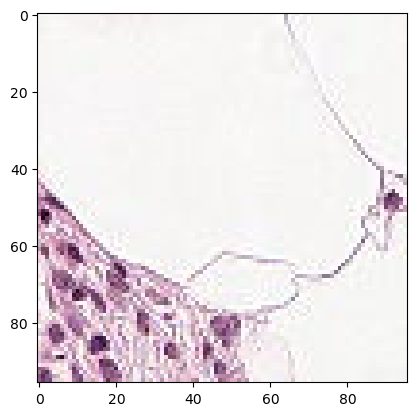

In [7]:
example_path = "/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

We have the images with size of (96,96,3) that is height is 96, width is 96, and we have 3 channels which are basic RGB channels. All the images has same shape in both train and test set.

Now we will create a dataframe to store id, label, and filename which will be used in training generator for fitting the data.

In [8]:
train_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels_df["filename"] = train_labels_df["id"].apply(train_img_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [9]:
train_labels_df.shape

(220025, 3)

In [11]:
set(train_labels_df['label'])

{'0', '1'}

We have 220,025 images in the train data set with 2 unique labels. 0 for not cancerous and 1 for cancerous tissues.

In [12]:
train_labels_df['label'].value_counts(normalize = True)

0    0.594969
1    0.405031
Name: label, dtype: float64

Around 40.5% of the train data set are cancerous tissues and 59.5% are tissues without cancerous tumor. Dataset is slightly unbalanced, but it is not to a limit that we may need to fine tune the data set.

In [13]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(len(train_labels_df))[:100]:
    img_path = train_img_path(train_labels_df['id'][i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

Non-Cancerous Images


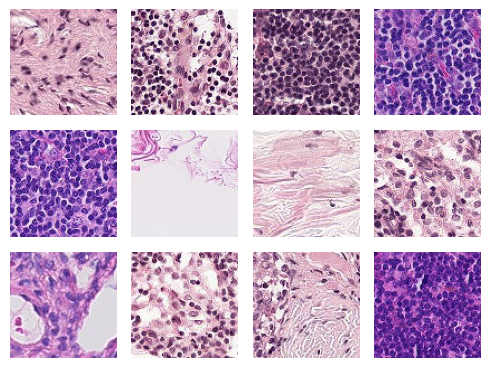

In [14]:
print("Non-Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancerous Images


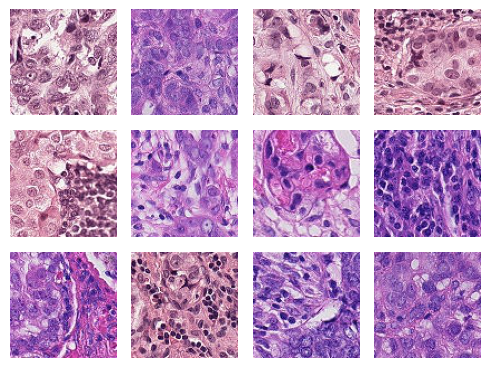

In [16]:
print("Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

From the above random images of the cancerous and non canceorus tissues we can see that tumor is not recognizable to an untrained human, for general populance both are not that different.

## 3. Model Designing

In this part we will perform various steps required to properly create the Resnet 50 model. We will load the data from the disk, specify train and validation data generators while creating test generator for the final submission.

We will then create a modified Resnet 50 suited for this task.

In [15]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [20]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [21]:
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [49]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 64,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 10
)

Found 57458 non-validated image filenames.


In [23]:
train_steps = 176020//32  # 8000 images for training
val_steps = 44005//32  

Now we will create Resnet50 model.

It is to be noted that we can actually use transfer learning and import the model and its trained parameters based on imagenet from the tensorflow API. But for this project we will create a modified model.

There will be two types of blocks, identity blocks where input and output dimension remains the same, and convolutional blocks where input and output dimensions are allowed to be changed. In both blocks we will use strong skip connections.

After convolutional we will use fully collected layers with output being a dense Sigmoid unit.

In the end we will have a Resnet model with 50 layers.

In [24]:
def identity_block(X, f, filters, training=True, initializer = random_uniform):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training)
    X = tfl.Activation('relu')(X)


    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)

    return X


In [25]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer = glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    X = tfl.Conv2D(filters = F2, kernel_size = (f,f), strides = 1, padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X) 

    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training) 

    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = (1,1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

In [26]:
def ResNet50(input_shape = (96, 96, 3)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tfl.Input(input_shape)

    
    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = tfl.Conv2D(96, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3,[256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = tfl.AveragePooling2D(pool_size = (2,2))(X)
    

    # output layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(1, kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [27]:
model = ResNet50(input_shape = (96, 96, 3))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 96)   14208       ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                   

Above is the model summary. We have 23,551,681 trainable parameters. If we use more deeper network number of parameters will increase with possible increase in Accuracy or AUC. But for this model we will use resnet 50 only.

## 4. Model Deployment

In this part we will use the model created and fit the model with Adam optimizer and loss as binary cross entropy. We have used from logits = True for better accuracy. If reader wants to avoid it they can modify the last output layer in Resnet50 above and make the Activation function as sigmoid instead of linear.

In [28]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics=['accuracy'])

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
5500/5500 [==============================] - 1493s 271ms/step - loss: 0.2986 - accuracy: 0.8710 - val_loss: 0.2734 - val_accuracy: 0.8760
Epoch 2/10
5500/5500 [==============================] - 612s 111ms/step - loss: 0.2357 - accuracy: 0.9026 - val_loss: 0.2340 - val_accuracy: 0.9121
Epoch 3/10
5500/5500 [==============================] - 514s 93ms/step - loss: 0.1954 - accuracy: 0.9216 - val_loss: 0.2060 - val_accuracy: 0.9209
Epoch 4/10
5500/5500 [==============================] - 505s 92ms/step - loss: 0.1708 - accuracy: 0.9326 - val_loss: 0.2656 - val_accuracy: 0.8784
Epoch 5/10
5500/5500 [==============================] - 498s 91ms/step - loss: 0.1520 - accuracy: 0.9411 - val_loss: 0.1964 - val_accuracy: 0.9253
Epoch 6/10
5500/5500 [==============================] - 490s 89ms/step - loss: 0.1387 - accuracy: 0.9464 - val_loss: 0.1537 - val_accuracy: 0.9443
Epoch 7/10
5500/5500 [==============================] - 492s 89ms/step - loss: 0.1274 - accuracy: 0.9514 - val_loss

It takes around 2 hours to train the model with 10 epochs and Kaggle P100 GPU. We can increase the number of epochs but only Training loss decrease for some time after 10 epochs with little change in validation loss and accuracy. In fact we can see from above that after 6th Epoch Validation Accruacy has not changed much.

So, it will not be efficient to train with more epochs but readers can do it if they have resources and time for this.

## 5. Model Evaluation

Model evaluation is limited here as we don't have test dataset labels. We will still perform basic evaluation and see why we cant do indepth model evaluation here.

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


val_predictions = tf.nn.sigmoid(model.predict(validation_generator)).numpy()
val_pred_classes = (val_predictions > 0.5).astype(int).flatten() #Threshold is assumed to be 0.5 for this cell

# True labels
true_labels = validation_generator.classes

# Ensure the lengths match
val_pred_classes = val_pred_classes[:len(true_labels)]

# Calculate metrics
accuracy = accuracy_score(true_labels, val_pred_classes)
precision = precision_score(true_labels, val_pred_classes)
recall = recall_score(true_labels, val_pred_classes)
f1 = f1_score(true_labels, val_pred_classes)
roc_auc = roc_auc_score(true_labels, val_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

1376/1376 [==============================] - 81s 58ms/step
Accuracy: 0.5192
Precision: 0.4012
Recall: 0.3868
F1 Score: 0.3939
ROC-AUC: 0.4997


Above we have used a threshold of 0.5 which is just assumed and is totally not correct. There was no decision boundary given with the dataset so we cant use above metrics to test the performance of the model.

In order to test the model performance we need to create a submission and get the AUC we will obtain from such submission.

In [ ]:
best_loss = history['val_loss'][i_min]
best_accuracy = history['val_accuracy'][i_min]
best_auc = history['val_auc'][i_min]

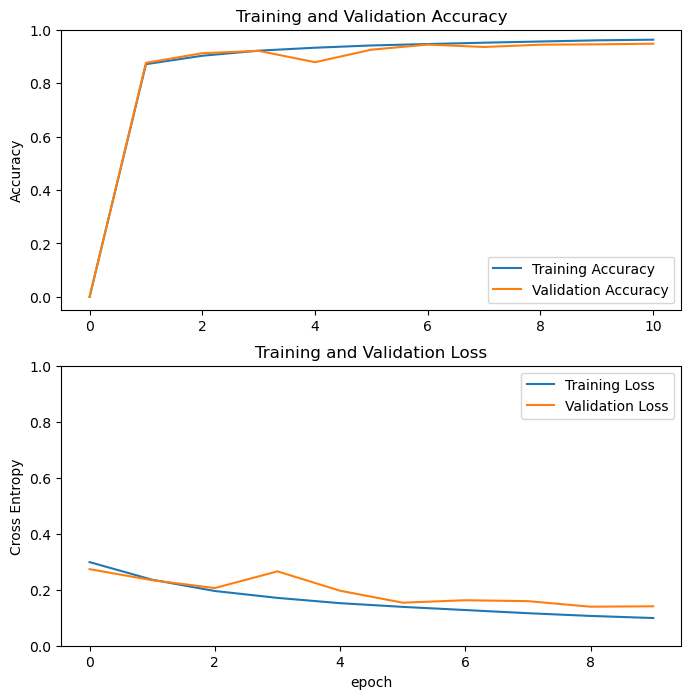

In [45]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As we can see from above images after few early epochs we cant see notable changes in Training and Valdiation metrics. While Training Binary Cross Entroy loss has a downward trend and its possible to get further low error Validation loss has more flat curve.

And for the accuracy both Training and Validation Accuracy has reached a satisfactory level beyond 0.94 after 6th epoch. There is little change after that. Also, since both Accuracies don't have big gaps we can assure that there is little to no Model Variance.

We will submit the file and get the AUC from final submission in next step.

## 6. Submission

In [60]:
test_probs = model.predict(test_generator)

898/898 [==============================] - 116s 129ms/step


In [58]:
test_labels = np.round(test_probs).astype(int).flatten()
out_df = pd.DataFrame()
out_df["id"] = test_ids
out_df["label"] = test_labels
out_df.to_csv(os.path.join('/kaggle/working/', "test_labels.csv"), index=False)

In [59]:
import shutil
submission_file = r"/kaggle/working/test_labels.csv"
shutil.copy(submission_file, "submission.csv")

'submission.csv'

## Conclusion

In the final submission we got the public area under the ROC curve or AUC score of 0.9463 and private score of 0.9167. This is acceptable result as we used only one deep Resnet Model of 50 layers. 

We can improve the score by creating even deeper neural network or by even using transfer learning and import Mobilenet or Inception-Resnet architectures or even more deeper architecture beyond 150 hidedn layer.

We can also improve the model accuracy by using data augmentation and increasing the size of training data set.

Overall with Resnet50 we got Test AUC of 0.9463 in Histopathological cancer detection data set. Traiing loss was 0.0989 with accuracy of 0.9627 and validation loss was 0.1408 with val_accuracy of 0.9476. We can strive to improve the model by using more deeper architecutes.